I found some cool artwork where a photo is triangulated, formed into a surface, such that it looks "normal" when viewed from the front.

<http://www.pauldilena.com/hex-peony1.html>

It would be cool to create one of these and have some semi automated way to go from the original photo to the transformed paper. (that would then have to be cut and assembled)

Steps:
- Start with an image
- Create a (2D) triangulation of the picture.
- "Lift" the triangulation into 3D.
- For each triangle, extract the relevant image piece, transform it, amend / annotate, return new image piece.
- Arrange all of these pieces together in 2D so they can be printed and cut out.
- Produce a map of what goes where.

In [1]:
import numpy as np
import matplotlib.pyplot as plt # for inline plotting

import cv2 # for processing

%matplotlib inline

In [2]:
def myimshow(cv2im, ax=None):
    
    img = cv2.cvtColor(cv2im, cv2.COLOR_BGR2RGB)
    
    if ax is None:
        fig = plt.figure(figsize=(8, 8))
        ax = fig.gca()

    ax.imshow(img)
    ax.set_xticks([])
    ax.set_yticks([])

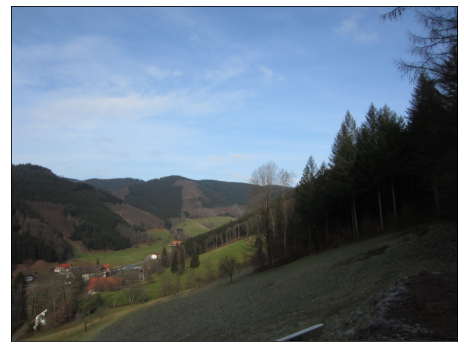

In [3]:
img = cv2.imread("./images/schwartzwald.jpg", 1) # We want a color picture

myimshow(img)

In [4]:
# height = img.shape[0]
# width = img.shape[1]
# print(height, width)

# mask = np.zeros((height, width), dtype=np.uint8)
# points = np.array([[[10,10],[1000,500],[500,2000]]])
# cv2.fillPoly(mask, points, (255))

# res = cv2.bitwise_and(img, img, mask = mask)

# myimshow(res)

In [5]:
# rect = cv2.boundingRect(points) # returns (x,y,w,h) of the rect
# cropped = res[rect[1]: rect[1] + rect[3], rect[0]: rect[0] + rect[2]]

# myimshow(cropped)

In [6]:
def cut_triangle_from_image(im, tri2D):
    height = im.shape[0]
    width = im.shape[1]
    print(height, width)

    mask = np.zeros((height, width), dtype=np.uint8)
    
#    tri2D = tri3D[:, [0, 1]]
    cv2.fillPoly(mask, [tri2D], (255))

    res = cv2.bitwise_and(im, im, mask = mask)
    
    rect = cv2.boundingRect(tri2D) # returns (x,y,w,h) of the rect
    cropped = res[rect[1]: rect[1] + rect[3], rect[0]: rect[0] + rect[2]]
    
    return cropped


def tri3D_to_normal(tri3D):
    """
    Given a triangle in 3D, return the normal vector.
    
    tri3D : [[x0, y0, z0], [x1, y1, z1], [x2, y2, z2]]
    """
    # Get two "side" vectors and form cross product.
    
    sA = tri3D[1, :] - tri3D[0, :]
    sB = tri3D[2, :] - tri3D[0, :]
    
    n = np.cross(sA, sB)
    n = n / np.sum(n**2)**0.5
    
    # TODO: check that this is always OK
    n = np.abs(n)
    
    return n
    
    
def normal_to_stretch_vec(n):
    """
    Given a normal vector, pointing away from the desired 3D triangle, return the vector in 2D that, when applied 
    to the original image, would yield a triangle that, when held in 3D, projects to the original image.
    
    For example, if the normal vector is (0, 0, 1), the triangle is 'flat' and so the stretch vector is (1, 1) - 
    the identity.
    
    Another example, if the normal vector is (1, 0, 1)/sqrt(2), the triangle is rotated 45 degrees about the y axis.
    The extent in x will be reduced. To compensate for this, we require a stretch in x so the stretch vector is 
    (sqrt(2), 1).
    
    Note: normal vectors do not have to be unit length.
    """
    
    # as the normal goes from upright down toward the x axis, the x stretch factor goes from 1 to infinity
    
    stretch_x = (n[0]**2 + n[2]**2)**0.5 / n[2]
    stretch_y = (n[1]**2 + n[2]**2)**0.5 / n[2]
    
    return (stretch_x, stretch_y)
    
def stretch_image(im, stretch_vec):
    # Might want to consider other interpolation methods.
    # also could try skimage.transform.rescale
    
    # Note: you have to pass in a final size even if you are using stretch factors
    # Apparently (0,0) is OK.
    return cv2.resize(im, (0, 0), fx=stretch_vec[0], fy=stretch_vec[1], interpolation=cv2.INTER_AREA)
    
    
def get_skewed_triangle_image(im, tri3D):
    """Given an image `im` and a triangle in 3D `tri3D`, return the triangular face that if held in the location of 
    `tri3D` and viewed from above would look like the image below.
    
    im : 
    tri3D : [[x0, y0, z0], [x1, y1, z1], [x2, y2, z2]]
    """

    tri2D = tri3D[:, [0,1]]
    cropped = cut_triangle_from_image(im, tri2D)
    
    n = tri3D_to_normal(tri3D)
    print("n", n)
    stretch_vec = normal_to_stretch_vec(n)    
    
    return stretch_image(cropped, stretch_vec)

3000 4000
n [0.74278135 0.37139068 0.55708601]
3000 4000
n [0. 0. 1.]


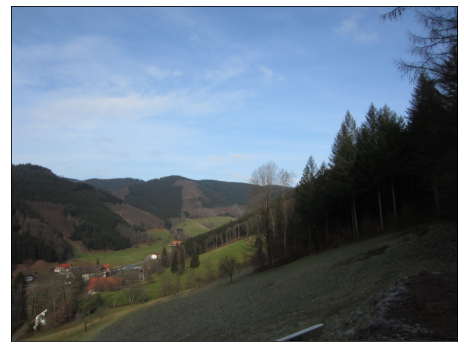

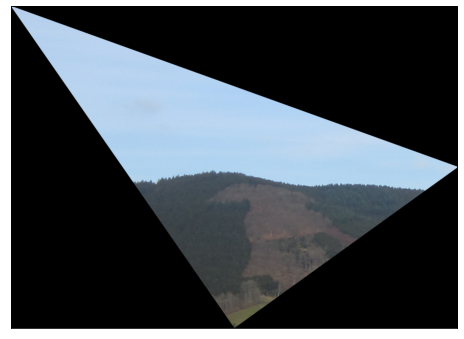

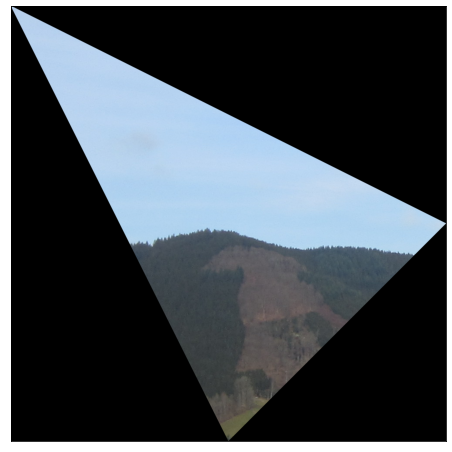

In [7]:
tri3DA = np.array([[1000, 1000, 0], [1500, 2000, 0], [2000, 1500, 1000]])
#tri3DB = np.array([[1000, 1000, 0], [1500, 2000, 0], [2000, 1500, 1000]])
tri3DB = np.array([[1000, 1000, 0], [1500, 2000, 0], [2000, 1500, 0]])

resA = get_skewed_triangle_image(img, tri3DA)
resB = get_skewed_triangle_image(img, tri3DB)

myimshow(img)
myimshow(resA)
myimshow(resB)

In [8]:
from scipy.spatial import Delaunay

def hex_triangulation(shape, Nx=6, Ny=4, fill_edges=True, add_centers=True):
    """
    Create a regular triangulation with dense triangles.
    
    Nx : number of triangles counting across
    Ny : number of triangles counting down
    
    """
    height = img.shape[0]
    width = img.shape[1]
    
    tri_width = width / Nx
    tri_height = height / Ny
    
    xsA = np.linspace(0, width, num=Nx + 1, endpoint=True)
    xsB = (xsA[:-1] + xsA[1:]) / 2
    
    xsB_fill_edges = np.array([0] + list(xsB) + [width])
    
    xs_add_centers = np.linspace(tri_width/2, width - tri_width/2, num=2*Nx - 1)
    
    all_ys = np.linspace(0, height, num=Ny + 1, endpoint=True)
    
    xs = []
    ys = []
    
    # Construct the main triangular lattice
    for yind in range(Ny + 1):
        if yind % 2 == 0:
            xs.extend(xsA)
            ys.extend(all_ys[yind] * np.ones(Nx + 1))
        else:
            if fill_edges:
                xs.extend(xsB_fill_edges)
                ys.extend(all_ys[yind] * np.ones((Nx + 2)))
            else:
                xs.extend(xsB)
                ys.extend(all_ys[yind] * np.ones((Nx - 0)))
                
    # Add center point to each triangle
    if add_centers:
        for yind in range(Ny):
            if yind % 2 == 0:
                xs.extend(xs_add_centers)
                ys.extend((all_ys[yind] + 1*tri_height/3)  * np.ones((2*Nx - 1)))
            else:
                xs.extend(xs_add_centers)
                ys.extend((all_ys[yind] + 2*tri_height/3) * np.ones((2*Nx - 1)))
    
    points2D=np.vstack([xs, ys]).T
    tri = Delaunay(points2D, incremental=True)

    return tri

def add_centers(img, tri, Nx, Ny):
    height = img.shape[0]
    width = img.shape[1]
    
    tri_width = width / Nx
    tri_height = height / Ny
    
    xs_add_centers = np.linspace(tri_width/2, width - tri_width/2, num=2*Nx - 1)
    
    all_ys = np.linspace(0, height, num=Ny + 1, endpoint=True)
    
    xs = []
    ys = []
                
    # Add center point to each triangle
    for yind in range(Ny):
        if yind % 2 == 0:
            xs.extend(xs_add_centers)
            ys.extend((all_ys[yind] + 1.4*tri_height/3)  * np.ones((2*Nx - 1)))
        else:
            xs.extend(xs_add_centers)
            ys.extend((all_ys[yind] + 2.2*tri_height/3) * np.ones((2*Nx - 1)))
    
    points2D=np.vstack([xs, ys]).T
    
    tri.add_points(points2D)

    return tri

def random_triangulation(shape):
    """Given an image shape, create a triangulation that consists of a regular array of equilateral triangles in a 
    hexagonal pattern where each triangle is then split into three equal sub-triangles.
    The height profile is such that each trio of sub-triangles forms a pyramid."""
    
    height = img.shape[0]
    width = img.shape[1]
    print(height, width)
    
    N = 100
    
    xs = np.random.uniform(low=0, high=width, size=N)
    ys = np.random.uniform(low=0, high=height, size=N)
    
    points2D=np.vstack([xs, ys]).T
    tri = Delaunay(points2D, incremental=True)
    
    return tri


(147, 2)
[[ 200.          142.85714286]
 [  66.66666667 1142.85714286]
 [ 400.          285.71428571]]
(92, 2)
(239, 2)
[   0.          400.          800.         1200.         1600.
 2000.         2400.         2800.         3200.         3600.
 4000.            0.          200.          600.         1000.
 1400.         1800.         2200.         2600.         3000.
 3400.         3800.         4000.            0.          400.
  800.         1200.         1600.         2000.         2400.
 2800.         3200.         3600.         4000.            0.
  200.          600.         1000.         1400.         1800.
 2200.         2600.         3000.         3400.         3800.
 4000.            0.          400.          800.         1200.
 1600.         2000.         2400.         2800.         3200.
 3600.         4000.            0.          200.          600.
 1000.         1400.         1800.         2200.         2600.
 3000.         3400.         3800.         4000.            0

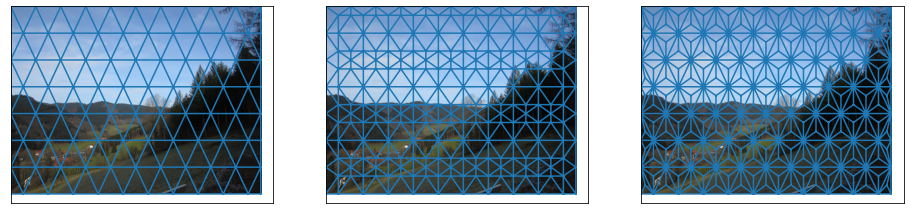

In [59]:
# tri = random_triangulation(img.shape)
Nx = 10
Ny = 7

tri1 = hex_triangulation(img.shape, Nx=Nx, Ny=Ny, add_centers=False)
tri2 = hex_triangulation(img.shape, Nx=Nx, Ny=Ny, add_centers=True)
tri3 = hex_triangulation(img.shape, Nx=Nx, Ny=Ny, add_centers=False)
#tri3 = add_centers(img, tri3, Nx=Nx, Ny=Ny)
tri3 = refine_each_triangle_to_3(tri3)
    
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(16, 8))

myimshow(img, ax=axs[0])
axs[0].triplot(tri1.points[:, 0], tri1.points[:, 1], tri1.simplices)

myimshow(img, ax=axs[1])
axs[1].triplot(tri2.points[:, 0], tri2.points[:, 1], tri2.simplices)

myimshow(img, ax=axs[2])
#axs[2].triplot(tri3.points[:, 0], tri3.points[:, 1], tri3.simplices)
axs[2].triplot(tri3)

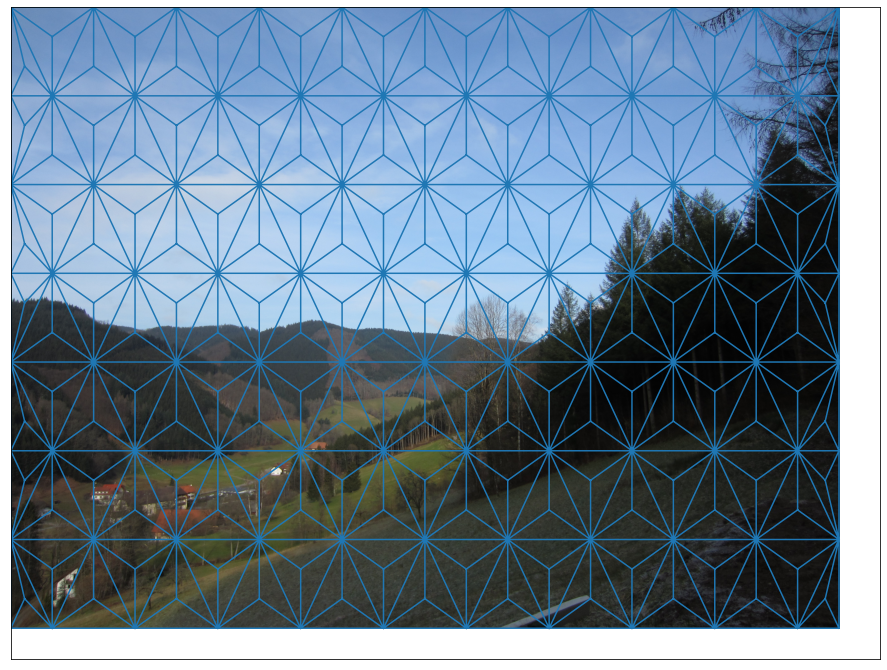

In [60]:
fig, ax = plt.subplots(figsize=(16, 12))
myimshow(img, ax)
#axs[2].triplot(tri3.points[:, 0], tri3.points[:, 1], tri3.simplices)
ax.triplot(tri3)

In [10]:
plt.close('all')

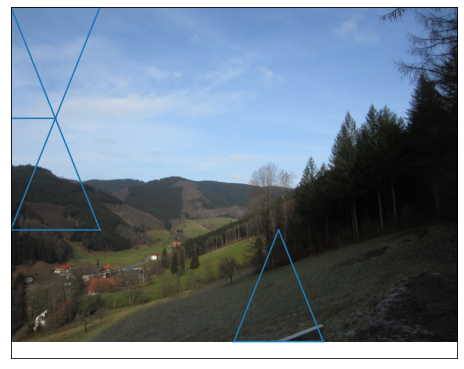

In [11]:
tri1.simplices = tri1.simplices[:5]

myimshow(img)
plt.triplot(tri1.points[:, 0], tri1.points[:, 1], tri1.simplices)

In [56]:
def refine_each_triangle_to_3(tri):
    """Given a triangulation, return a refined triangulation where each triangle is turned into three.
    
    For each simplex, we find the center point, add it, remove the original simplex and replace it with the three 
    refinements."""
    
    num_simplices = len(tri.simplices) # Do we need to record this so we know what to cut later?
    
    new_pts = []
    new_simplices = []
    
    point_index = len(tri.points)
    
    for sim in tri.simplices:
        center_pt = np.sum(tri.points[sim, :], axis=0) / 3
        new_pts.append(center_pt)
        
        # TODO: Do we need to worry about orientation here?
        new_simplices.append([point_index, sim[0], sim[1]])
        new_simplices.append([point_index, sim[1], sim[2]])
        new_simplices.append([point_index, sim[2], sim[0]])
        
        point_index += 1
    
    new_pts = np.array(new_pts)
    print(new_pts.shape)
    print(new_pts[0:3])
    print(tri.points.shape)
    all_points = np.vstack((tri.points, new_pts))
    print(all_points.shape)
    
    print("================")
    print(all_points[:, 0])
    print("================")
    print(all_points[:, 1])
    print("================")
    print(new_simplices)
    print("================")
    return mpl.tri.Triangulation(all_points[:, 0], all_points[:, 1], triangles=new_simplices)

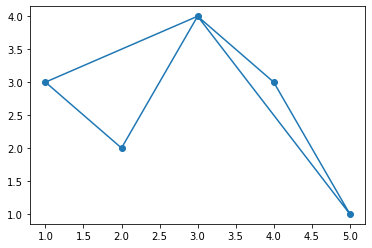

In [50]:
test = mpl.tri.Triangulation(np.array([1, 2, 3, 4, 5]),
                             np.array([3, 2, 4, 3, 1]), 
                             np.array([[0, 1, 2], [2, 3, 4]]))

plt.scatter(test.x, test.y)
plt.triplot(test)

In [13]:
test.

In [14]:
a = mpl.tri.Triangulation(tri1.points[:, 0], tri1.points[:, 1], tri1.simplices)

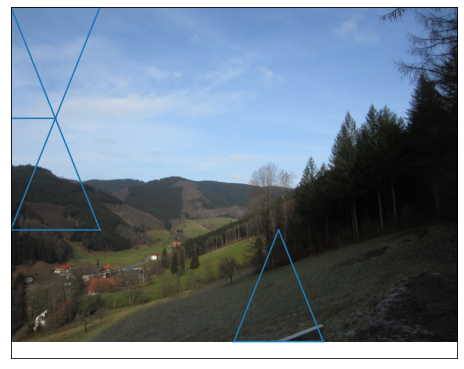

In [16]:
myimshow(img)
plt.triplot(a)